# DataCamp Certification Case Study

### Project Brief

You have been hired as a data scientist at Discount Motors, a used car dealership in the UK. The dealership is expanding and has hired a large number of junior salespeople. Although promising, these junior employees have difficulties pricing used cars that arrive at the dealership. Sales have declined 18% in recent months, and management would like your help designing a tool to assist these junior employees.

To start with, they would like you to work with the Toyota specialist to test your idea(s). They have collected some data from other retailers on the price that a range of Toyota cars were listed at. It is known that cars that are more than £1500 above the estimated price will not sell. The sales team wants to know whether you can make predictions within this range.

You will need to present your findings in two formats:
- You must submit a written report summarising your analysis to your manager. As a data science manager, your manager has a strong technical background and wants to understand what you have done and why. 
- You will then need to share your findings with the head of sales in a 10 minute presentation. The head of sales has no data science background but is familiar with basic data related terminology. 

The data you will use for this analysis can be accessed here: `"data/toyota.csv"`

## Result Conclusion:
- XGBoost regression model performs well in estimating the price of used cars, with a few tradeoffs:
    1. there is an average of $74 lower in price per car compare to the true price
    2. there is approximately 3.7% of the cars will be priced at over $1500 higher than the true price.
- The most importance features identitied by XGBoost, ranked from the most important down, are Milage, MPG, Year, Engine size.

## Future work:
- Analyze the overpriced set to help salemen aware of typical machine-overpriced car features
  
## Note on deployment
- Model doesn't account for title, cosmetic condition, engine condition, etc. Please adjust accordingly


## Data Exploratory

In [ ]:
# Use this cell to begin, and add as many cells as you need to complete your analysis!
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('toyota.csv')
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [ ]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000
mean,2016.748145,12522.391066,22857.413921,94.697240,63.042223,1.471297
std,2.204062,6345.017587,19125.464147,73.880776,15.836710,0.436159
min,1998.000000,850.000000,2.000000,0.000000,2.800000,0.000000
25%,2016.000000,8290.000000,9446.000000,0.000000,55.400000,1.000000
50%,2017.000000,10795.000000,18513.000000,135.000000,62.800000,1.500000
75%,2018.000000,14995.000000,31063.750000,145.000000,69.000000,1.800000
max,2020.000000,59995.000000,174419.000000,565.000000,235.000000,4.500000


**Note on the dataset:**

data is clean. All values are in reasonable range

Text(0.5, 1.0, 'Price')

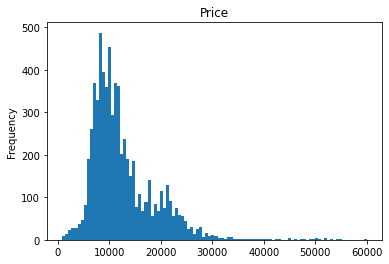

In [ ]:
# prices histogram
df.price.plot.hist(bins=100).set_title('Price')

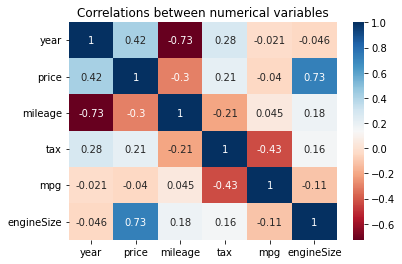

In [ ]:
# correlations of the numerical features
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu', annot=True).set_title('Correlations between numerical variables')
plt.show()

**Note on correlations**

Engine Size and mileage have high correlations with the price. This makes sense in the market. We well see later whether our machine learning model reflect this

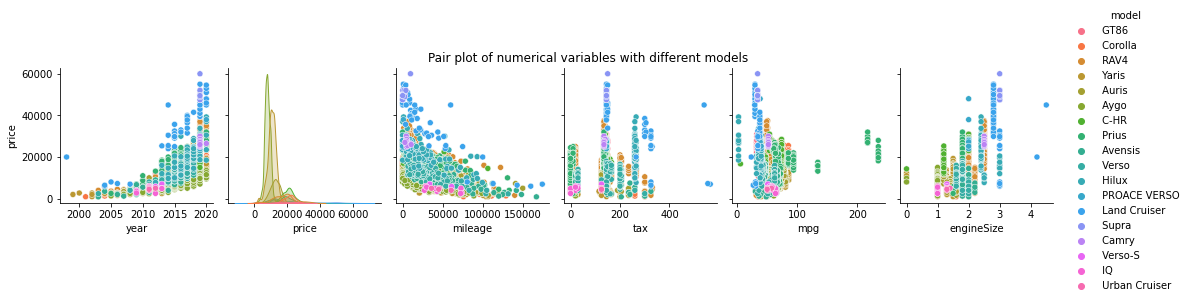

In [ ]:
g = sns.pairplot(df, y_vars=['price'], hue='model')
g.fig.suptitle('Pair plot of numerical variables with different models', y = 1.05)
plt.show()

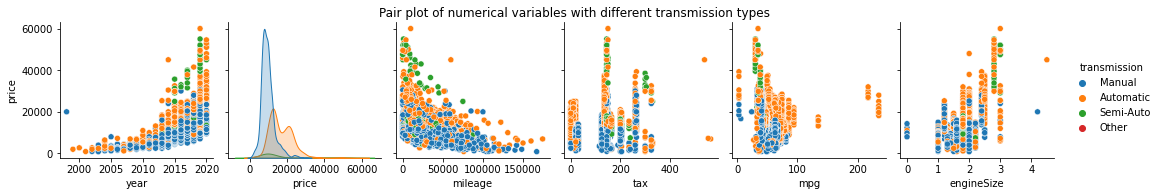

In [ ]:
g = sns.pairplot(df, y_vars=['price'], hue='transmission')
g.fig.suptitle('Pair plot of numerical variables with different transmission types', y = 1.05)
plt.show()

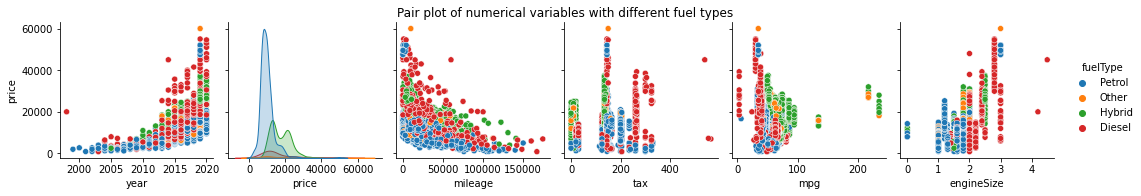

In [ ]:
g = sns.pairplot(df, y_vars=['price'], hue='fuelType')
g.fig.suptitle('Pair plot of numerical variables with different fuel types', y = 1.05)
plt.show()

**Note on Graph:**
- year, engine size have positive correlations to price
- mileage shows a negative correlation to price.
- hybrid and semiauto seem to correlate, and are priced higher than other types.

## Set Metrics for evaluation:
1. mean absolute error: average price difference evaluated and true price
2. mean error: average return difference between evaluated and true price
3. overpriced percent: percentage of cars that won't sell (since predicted prices are $1500 greater than the true price)

## Base model: Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error as MAE
import statistics

X = df.drop('price', axis = 1)
X = pd.get_dummies(X)
y = df.price

me = [] # mean error
mae = [] # mean absolute error
overpriced = [] # percentage of cars that won't be sold

kfold = KFold(n_splits=10, shuffle=True, random_state=312)

for train_ix, test_ix in kfold.split(X):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
    # initialize model
    model = LinearRegression()
    
    # fit model
    model.fit(X_train, y_train)
    
    # predict and score
    y_pred = model.predict(X_test)
    
    me.append((y_pred - y_test).mean())
    mae.append(MAE(y_test, y_pred))
    overpriced.append(((y_pred - y_test) >1500).mean())

# print('Mean errors each folds: \n', me)
# print('Mean absolute errors each folds: \n', mae)
# print('percent overpriced: \n', overpriced)
# print()
print('Average of mean errors over all folds: %.2f' % statistics.mean(me))
print('Average of mean absolute error over all folds: %.2f' % statistics.mean(mae))
print('Average of mean percent percent overpriced over all folds: %.7f' % statistics.mean(overpriced))

Average of mean errors over all folds: -1.29
Average of mean absolute error over all folds: 1085.66
Average of mean percent percent overpriced over all folds: 0.0997308


## Extreme Gradient Boosting (XGBoost)

**Quick try out**

In [ ]:
import xgboost
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import max_error, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statistics

X = df.drop('price', axis = 1)
X = pd.get_dummies(X)
y = df.price

me = [] # mean errors
mae = [] # mean absolute errors
overpriced = [] # percentage of cars that won't be sold

me_train = [] # mean errors
mae_train = [] # mean absolute errors
overpriced_train = [] # percentage of cars that won't be sold

# split train_test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0)

# create XGBoost model
xgb = xgboost.XGBRegressor()

# create and fit scaler
scaler.fit_transform(X_train)
scaler.transform(X_test)

# fit and predict
xgb.fit(X_train, y_train)
y_pred_train = xgb.predict(X_train)
y_pred = xgb.predict(X_test)

# score training set
mae_train = mean_absolute_error(y_train, y_pred_train)
me_train = (y_pred_train - y_train).mean()
overpriced_train = ((y_pred_train - y_train)>1600).mean()

# score testing set
mae = mean_absolute_error(y_test, y_pred)
me = (y_pred - y_test).mean()
overpriced = ((y_pred - y_test)>1600).mean()

print('Mean errors each folds: %.2f\n' % me_train)
print('Mean absolute errors each folds: %.2f\n' % mae_train)
print('percent overpriced: %.5f\n\n' % overpriced_train)
print('Mean errors each folds: %.2f\n' % me)
print('Mean absolute errors each folds: %.2f\n' % mae)
print('percent overpriced: %.5f\n' % overpriced)

[20:45:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean errors each folds: -0.69

Mean absolute errors each folds: 800.86

percent overpriced: 0.05380


Mean errors each folds: 28.14

Mean absolute errors each folds: 859.33

percent overpriced: 0.06751



**Tune hyperparameter to reduce overfitting**

In [ ]:
# split train_test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0)

# create model
scaler = StandardScaler()
xgb = xgboost.XGBRegressor()
model = Pipeline([('scaler', StandardScaler()),
                 ('xgb', xgboost.XGBRegressor())])
cv = KFold(n_splits=10, shuffle=True, random_state=0)

# create parameter grid
grid = {'xgb__importance_type' : ['total_cover','gain', 'cover'],
        'xgb__learning_rate' : [0.3,0.2,0.1,0.05,0.01,0.005],
        'xgb__subsample' : [0.7,0.8,0.9,1], 'xgb__colsample_bytree' : [0.7,0.8,0.9,1],
        'xgb__max_depth' : [4,6,8,10,12], 'xgb__min_child_weight' : range(5,8)}

# perform grid search
# use neg_mean_squared_error to increase penalty on far off predictions
gridsearch = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', cv=cv)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

**Apply fine-tuned model on the entire set**


In [ ]:
# create XGBoost model with best parameters from Gridsearch
xgb_tuned = xgboost.XGBRegressor(importance_type='total_cover', max_depth=8, min_child_weight=7, subsample=0.9, learning_rate=0.1)

# fit and predict
xgb_tuned.fit(X_train, y_train)
y_pred_train = xgb_tuned.predict(X_train)
y_pred = xgb_tuned.predict(X_test)

# score training set
mae_train = mean_absolute_error(y_train, y_pred_train)
me_train = (y_pred_train - y_train).mean()
overpriced_train = ((y_pred_train - y_train)>1600).mean()

# score testing set
mae = mean_absolute_error(y_test, y_pred)
me = (y_pred - y_test).mean()
overpriced = ((y_pred - y_test)>1600).mean()

print('Mean errors each folds: %.2f\n' % me_train)
print('Mean absolute errors each folds: %.2f\n' % mae_train)
print('percent overpriced: %.5f\n\n' % overpriced_train)
print('Mean errors each folds: %.2f\n' % me)
print('Mean absolute errors each folds: %.2f\n' % mae)
print('percent overpriced: %.5f\n' % overpriced)

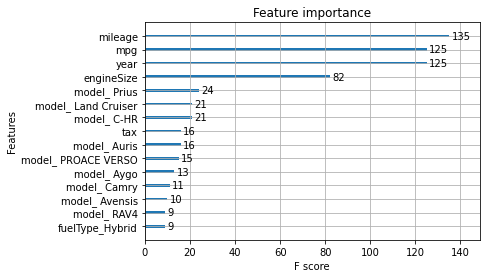

In [ ]:
# Get feature importance
from xgboost import plot_importance
plot_importance(model, max_num_features = 15)
plt.show()

## XGBoost evaluation
- XGBoost achieved 4.1% overpricing rate, 5.9% improvement from the base model
- Important features include Mileage, MPG, Year, engineSize. Need to find better way to show importance score of categorical variable.